(cardiac_cycles)=
# Detecting cardiac cycles
Author: Nicolas Legrand <nicolas.legrand@cfin.au.dk>

In [1]:
%%capture
import sys
if 'google.colab' in sys.modules:
    !pip install systole

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from systole.detection import interpolate_clipping, ecg_peaks
from systole.plots import plot_raw
from systole import import_dataset1, import_ppg
from systole import serialSim
from systole.recording import Oximeter

from bokeh.io import output_notebook
from bokeh.plotting import show
output_notebook()

sns.set_context('talk')

Loading BokehJS ...

This notebook focuses on the characterisation of cardiac cycles from the physiological signals we previously described (PPG and ECG). Here we only briefly mention different QRS-detection algorithms as related to the estimation of heart rate frequency, which is a commonly used measure in psychology and cognitive science. However, both the ECG and the PPG signals contain rich information beyond the beat-to-beat frequency that is relevant for cognitive and physiological modelling. All these approaches are not fully covered by [Systole](https://LegrandNico.github.io/systole/#), but are implemented in other software (e.g. see {cite:p}`2021:makowski` for ECG components delineation).

In this notebook, we are going to review the peak detection algorithm, which future tutorials covering, for example, heart-rate variability will build upon. Here our intention is to provide a better intuition of what is happening in our peak detection algorithms, the corrections that can be applied, and the possible bias and artefacts that can emerge. However, you do not need a perfect understanding of all these steps if you want to apply peak detection to your data, and you might also consider skipping this part to proceed directly to the next tutorial focusing on artefact detection and correction.

## Electrocardiography

Because we will ultimately be interested in heart rate and its variability, our first goal will be to detect the R peaks. A large variety of algorithms have been proposed to extract the timing of R waves while controlling for signal noise and physiological variability. Reviewing and comparing all of the available methods is beyond the scope of this tutorial. Here, we are going to restrict our focus to some of the most popular methods, which also are available in the Python open-source ecosystem. We will use the {py:func}`systole.detection.ecg_peaks` function to perform R peak detection. This function can call a variety of peak detection algorithms among the following: 

- `sleepecg` (default)
- `hamilton`
- `christov`
- `engelse-zeelenberg`
- `pan-tompkins`
- `wavelet-transform`
- `moving-average`

The default method (`sleepecg`) uses a modified version of the Pan-Tompkins algorithm provided by the [sleepecg](https://github.com/cbrnr/sleepecg) package. The rest of the algorithms were implemented in the [py-ecg-detectors module](https://github.com/berndporr/py-ecg-detectors) {cite:p}`2019:porr`. Systole uses a modified version of these implementations that runs with the [Numba](http://numba.pydata.org/) package for better performance, resulting in 7-30x faster estimation, depending on the algorithm.

The detection algorithm can be selected via the `method` parameter. In these tutorials, we will use the modified version of the [pan-tompkins algorithm](https://en.wikipedia.org/wiki/Pan%E2%80%93Tompkins_algorithm) {cite:p}`1985:pan` from [sleepecg](https://github.com/cbrnr/sleepecg) as it is a fast, well-performing, and a commonly used algorithm for QRS detection.

Let's first load an ECG recording. Here, we will select a 5-minute interval and compare the performances of the different algorithms supported by Systole.

In [3]:
# Import ECG recording
ecg_df = import_dataset1(modalities=['ECG'], disable=True)
signal = ecg_df[ecg_df.time.between(60, 360)].ecg.to_numpy()  # Select 5 minutes

### Detecting R peaks

In [4]:
from systole.detectors import pan_tompkins, hamilton, moving_average, christov, engelse_zeelenberg

#### Pan-Tompkins

The [Pan-Tompkins algorithm](https://en.wikipedia.org/wiki/Pan%E2%80%93Tompkins_algorithm) was introduced in 1985. It uses band-pass filtering and derivation to identify the QRS complex and apply an adaptive threshold to detect the R peaks on the filtered signal.

This is a very popular - maybe the most popular - method for R peak detection. One of the advantages is that it can easily be applied for online detection (see [this implementation](https://github.com/c-labpl/qrs_detector) for example). As we can see in the timing report, this algorithm is also the fastest among those available in the Systole toolbox, making it ideal for applications such as online peak detection and biofeedback. You can also see that the algorithm's peak detection is highly accurate as we do not see any artifacts in the estimated R-R time series. One notable exception is the first peak which has been estimated incorrectly. This is due to the filtering steps in the Pan-Tompkins algorithms and can be corrected by using a slightly longer signal than the range of interest.

In [5]:
%%timeit
peaks_pt = pan_tompkins(signal, sfreq=1000)

7.4 ms ± 2.14 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [6]:
show(
    plot_raw(signal, modality='ecg', detector='pan-tompkins', backend='bokeh', show_heart_rate=True)
)

#### Moving average

In [7]:
%%timeit
peaks_wa = ecg_peaks(signal, sfreq=1000, method="moving-average")

8.91 ms ± 943 μs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [8]:
show(
    plot_raw(signal, modality='ecg', detector='moving-average', backend='bokeh', show_heart_rate=True)
)

#### Hamilton

In [9]:
%%timeit
peaks_ha = hamilton(signal, sfreq=1000)

10.4 ms ± 5.05 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [10]:
show(
    plot_raw(signal, modality='ecg', detector='hamilton', backend='bokeh', show_heart_rate=True)
)

#### Christov

In [11]:
%%timeit
peaks_ch = christov(signal, sfreq=1000)

120 ms ± 4.46 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [12]:
show(
    plot_raw(signal, modality='ecg', detector='christov', backend='bokeh', show_heart_rate=True)
)

#### Engelse-Zeelenberg

In [13]:
%%timeit
peaks_ew = engelse_zeelenberg(signal, sfreq=1000)

37.3 ms ± 1.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [14]:
show(
    plot_raw(signal, modality='ecg', detector='engelse-zeelenberg', backend='bokeh', show_heart_rate=True)
)

## Photoplethysmography

### Online systolic peaks detection

Let's first simulate some PPG recording. Here, we will use the `serialSim` class from Systole in conjunction with the `Oximeter` recording class. This will *simulate* the presence of a pulse oximeter on the computer and provide the information from a pre-recorded signal in real-time. Simulating synthetic cardiac data in this way can be a great way to test your data analysis pipelines before collecting data - avoiding painful mistakes that can occur!

In [15]:
# Pulse oximeter simulation
ser = serialSim()

# Create an Oxymeter instance, initialize recording and record for 10 seconds
oxi = Oximeter(serial=ser, sfreq=75).setup()
oxi.read(20);

Reset input buffer


In [16]:
# Retrieve the data from the oxi class
times = np.array(oxi.times)
threshold = np.array(oxi.threshold)
recording = np.array(oxi.recording)
peaks = np.array(oxi.peaks)

This method uses the derivative to find peaks in the signal and select them based on and adaptive threshold based on the rolling mean and rolling standard deviation in a given time window.

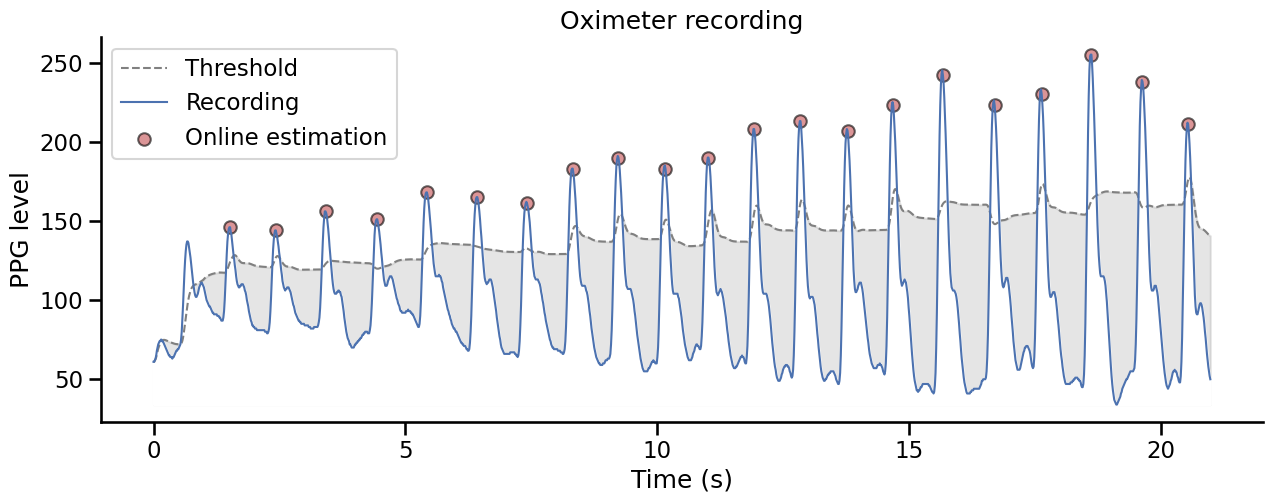

In [17]:
fig, ax = plt.subplots(figsize=(15, 5))
ax.set_title("Oximeter recording")

ax.plot(times, threshold, linestyle="--", color="gray", label="Threshold", linewidth=1.5)
ax.fill_between(
    x=times, y1=threshold, y2=recording.min(), alpha=0.2, color="gray"
)
ax.plot(times, recording, label="Recording", color="#4c72b0", linewidth=1.5)
ax.fill_between(x=times, y1=recording, y2=recording.min(), color="w")
ax.scatter(x=times[np.where(peaks)[0]], y=recording[np.where(peaks)[0]],
           color="#c44e52", alpha=.6, label="Online estimation",
           edgecolors='k')
ax.set_ylabel("PPG level")
ax.set_xlabel("Time (s)")
ax.legend()
sns.despine()

### Offline systolic peaks detection

In [18]:
ppg = import_ppg()

A simple online approach like the one we described is usually good enough to detect all the systolic peaks, provided that the subject is not moving too much. The package comes with two algorithms for systolic peaks detection presented below and that can be controlled through the `method` parameter of the {py:func}`systole.detection.ppg_peaks`.

#### Rolling mean

The current default is an adaptation of the rolling mean method proposed by {cite:p}`2019:vanGent`. This method has the advantage of being fast, simple and performing well when the signal-to-noise ratio is good.

In [19]:
show(
    plot_raw(signal=ppg, modality="ppg", detector="rolling_average", sfreq=75, backend="bokeh")
)

#### The Multi-scale peak and trough detection algorithm

Systole also includes a version of the Multi-scale peak and trough detection algorithm {cite:p}`bishop:2018`, which has been reported to be one of the best-performing algorithms in recent benchmark {cite:p}`kotzen:2021`.

In [20]:
show(
    plot_raw(signal=ppg, modality="ppg", detector="msptd", sfreq=75, backend="bokeh")
)

### Clipping artefacts

Clipping is a form of distortion that can limit signal when it exceeds a certain threshold [see the Wikipedia page](https://en.wikipedia.org/wiki/Clipping_(signal_processing)). Some PPG devices can produce clipping artefacts when recording the PPG signal, for example, if a participant is pressing too hard on the finger clip. Here, we can see that some clipping artefacts are found between 100 and 150 seconds in the previous recording. The threshold value (here `255`), is often set by the device and can easily be found depending on the manufacturer. These artefacts should be corrected before systolic peak detection. One way to correct these artefacts is to remove the portion of the signal where clipping artefacts occur and use cubic spline interpolation to reconstruct a plausible estimate of the *real* underlying signal. This is what the function `interpolate_clipping()` does {cite:p}`2019:vanGent`.

In [21]:
signal = ppg[ppg.time.between(110, 113)].ppg.to_numpy()  # Extract a portion of signal with clipping artefacts
clean_signal = interpolate_clipping(signal, min_threshold=0, max_threshold=255)  # Remove clipping segment and interpolate missing calues

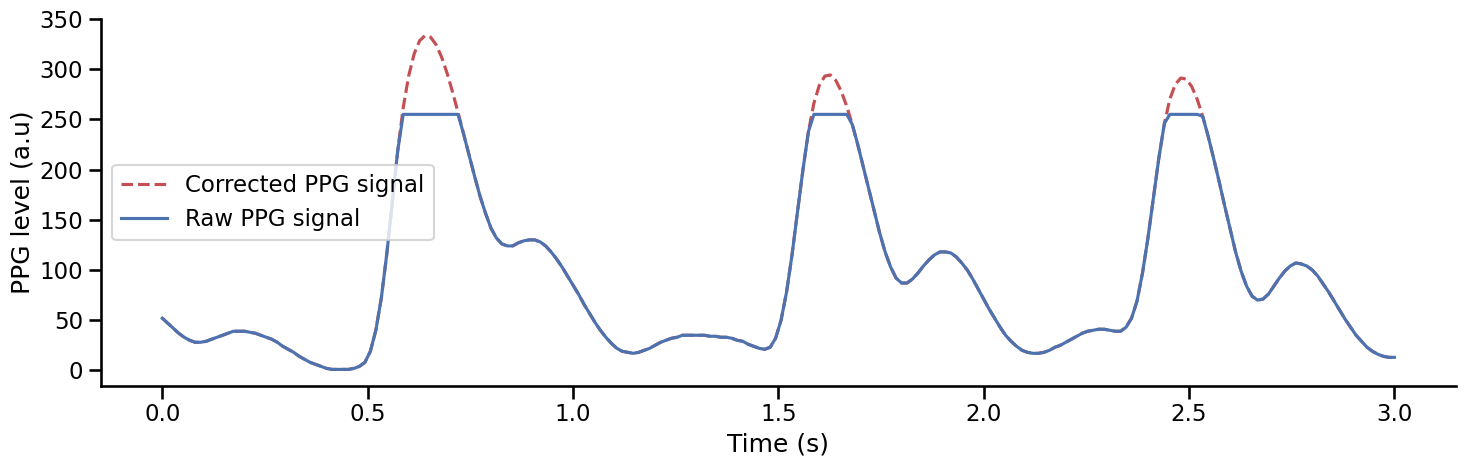

In [22]:
plt.figure(figsize=(15, 5))
plt.plot(np.arange(0, len(clean_signal))/75, clean_signal, label='Corrected PPG signal', linestyle= '--', color='#c44e52')
plt.plot(np.arange(0, len(signal))/75, signal, label='Raw PPG signal', color='#4c72b0')
plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('PPG level (a.u)')
sns.despine()
plt.tight_layout()

This concludes the tutorial on using Systole to detect individual heartbeats and to reject common ECG and PPG artefacts. The next tutorial will go further into more nuanced issues in artefact detection and correction.

# System configuration

In [23]:
%load_ext watermark
%watermark -n -u -v -iv -w -p systole,numba

Last updated: Mon Apr 07 2025

Python implementation: CPython
Python version       : 3.13.2
IPython version      : 9.0.2

systole: 0.0.0
numba  : 0.61.0

matplotlib: 3.10.1
bokeh     : 3.7.2
systole   : 0.0.0
seaborn   : 0.13.2
sys       : 3.13.2 (main, Mar 11 2025, 17:25:02) [Clang 20.1.0 ]
numpy     : 2.1.3

Watermark: 2.5.0

